In [5]:
import sys
import gc
import os
from tqdm import tqdm
import time

import numpy as np
import pickle
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as transforms
from PIL import Image


# Pytorch 1.9
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions

# Pytorch3d
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesVertex,
    blending
)

import open3d as o3d

# facenet-pytorch 2.5.2
from facenet_pytorch import MTCNN, InceptionResnetV1

# face-alignment 1.3.4
import face_alignment

#######################################
## Setup PyTorch
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print('CUDA is available. Device: ', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('CUDA is NOT available. Use CPU instead.')
    
    

CUDA is available. Device:  NVIDIA GeForce RTX 3070


In [6]:
shape_path = '../../datasets/FFHQ/raw_bfm_shape/'
file_indices = []
for fname in os.listdir(shape_path):
    if fname.endswith('.npy'):
        file_indices.append(fname.split('.')[0])
shape_path += '{}.npy'

ffhq_meanshape = np.load('../ffhq_meanshape.npy')




In [7]:
"""
 1: face skin
 2: eye brows
 3: eyes
 4: nose
 5: upper lip
 6: lower lip
"""
label_map = {
    'skin': 1,
    'eye_brow': 2,
    'eye': 3,
    'nose': 4,
    'u_lip': 5,
    'l_lip': 6
}

## Load the face parsing labels (per-vertex)
vert_labels = np.load('../../BFM/bfm_vertex_labels.npy')
print(set(vert_labels))


## Load the BFM model
import pickle
with open('../../BFM/bfm09.pkl', 'rb') as f:
    bfm = pickle.load(f)
print('BFM model loaded\n')

## Triangal Facets
Faces = bfm['tri'] - 1 ## -1 is critical !!!

# find the vertices of part
part_vertices = {
    'S_overall':[],
    #'S_rest':[],
    'S_eyebrows':[],
    'S_eyes':[],
    'S_llip':[],
    'S_nose':[],
    'S_ulip':[]
}
for idx in range(len(vert_labels)):
    part_vertices['S_overall'].append(idx)
    if vert_labels[idx] in [label_map['eye_brow']]:
        part_vertices['S_eyebrows'].append(idx)
    if vert_labels[idx] in [label_map['eye']]:
        part_vertices['S_eyes'].append(idx)
    if vert_labels[idx] in [label_map['l_lip']]:
        part_vertices['S_llip'].append(idx)
    if vert_labels[idx] in [label_map['u_lip']]:
        part_vertices['S_ulip'].append(idx)
    if vert_labels[idx] in [label_map['nose']]:
        part_vertices['S_nose'].append(idx)
    
for key in part_vertices:
    part_vertices[key] = np.array(part_vertices[key])
    print(key, ' n_vert: ', len(part_vertices[key]))

{1, 2, 3, 4, 5, 6}
BFM model loaded

S_overall  n_vert:  35709
S_eyebrows  n_vert:  444
S_eyes  n_vert:  586
S_llip  n_vert:  309
S_nose  n_vert:  1711
S_ulip  n_vert:  576


In [9]:
bfm_68_landmarks = bfm['keypoints'][0] # mapping between 68 landmarks and their bfm vertices

def landmark_2_vertex(landmark_idx):
    """convert landmark (1~68) to corresponding bfm vertex index"""
    return bfm_68_landmarks[landmark_idx-1]

def bounding_box_height(shape, vertices):
    y_max = np.max(shape[0, vertices, 1])
    y_min = np.min(shape[0, vertices, 1])
    height = y_max - y_min
    return height

def bounding_box_width(shape, vertices):
    x_max = np.max(shape[0, vertices, 0])
    x_min = np.min(shape[0, vertices, 0])
    width = x_max - x_min
    return width



def nose_tip_y(ffhq_meanshape, shape):
    """ the y-axis offset (+: up, -: down) of nose tip """
    kpt_a = landmark_2_vertex(31) # nose tip keypoint (31)
    y_offset = shape[0, kpt_a, 1] - ffhq_meanshape[0, kpt_a, 1]
    return y_offset
    
def nose_tip_z(ffhq_meanshape, shape):
    """ the z-axis offset (+: out, -: in) of nose tip """
    kpt_a = landmark_2_vertex(31) # nose tip keypoint (31)
    z_offset = shape[0, kpt_a, 2] - ffhq_meanshape[0, kpt_a, 2]
    return z_offset

def nose_height(ffhq_meanshape, shape):
    """ the height offset of nose """
    height_mean = bounding_box_height(ffhq_meanshape, part_vertices['S_nose'])
    height = bounding_box_height(shape, part_vertices['S_nose'])
    return height - height_mean

def nose_width(ffhq_meanshape, shape):
    """ the width offset of nose """
    width_mean = bounding_box_width(ffhq_meanshape, part_vertices['S_nose'])
    width = bounding_box_width(shape, part_vertices['S_nose'])
    return width - width_mean

def nose_tip_width(ffhq_meanshape, shape):
    """ the width offset of nose tip """
    v1 = 7830
    v2 = 8550
    width_mean = abs(ffhq_meanshape[0, v1, 0] - ffhq_meanshape[0, v2, 0])
    width = abs(shape[0, v1, 0] - shape[0, v2, 0])
    return width - width_mean


def nose_bridge_width(ffhq_meanshape, shape):
    """ the width offset of nose bridge """
    v1 = 7453
    v2 = 8893
    width_mean = abs(ffhq_meanshape[0, v1, 0] - ffhq_meanshape[0, v2, 0])
    width = abs(shape[0, v1, 0] - shape[0, v2, 0])
    return width - width_mean
    



In [10]:
"""
Measure the shapes and record in a matrix
"""
measurements_nose = np.zeros([len(file_indices), 6])

for i in tqdm(range(len(file_indices))):
    file_idx = file_indices[i]
    shape = np.load(shape_path.format(file_idx))
    
    measurements_nose[i, 0] = nose_tip_y(ffhq_meanshape, shape)
    measurements_nose[i, 1] = nose_tip_z(ffhq_meanshape, shape)
    measurements_nose[i, 2] = nose_height(ffhq_meanshape, shape)
    measurements_nose[i, 3] = nose_width(ffhq_meanshape, shape)
    measurements_nose[i, 4] = nose_tip_width(ffhq_meanshape, shape)
    measurements_nose[i, 5] = nose_bridge_width(ffhq_meanshape, shape)
    
   


100%|███████████████████████████████████████████████████████████████████████████| 68422/68422 [10:17<00:00, 110.75it/s]


     Tip -y    Tip -z    Height     Width  Tip Width  Bridge Width
0  0.054096 -0.096543 -0.091341  0.006215  -0.009208      0.011179
1 -0.015780  0.041876  0.012849 -0.024109  -0.003759     -0.004069
2 -0.001079 -0.048639 -0.033789  0.073253   0.013974      0.012234
3  0.035920 -0.125629 -0.056526  0.000138  -0.018668     -0.004749
4 -0.029867  0.055084  0.041664 -0.006991   0.012719      0.005030


<Figure size 720x720 with 0 Axes>

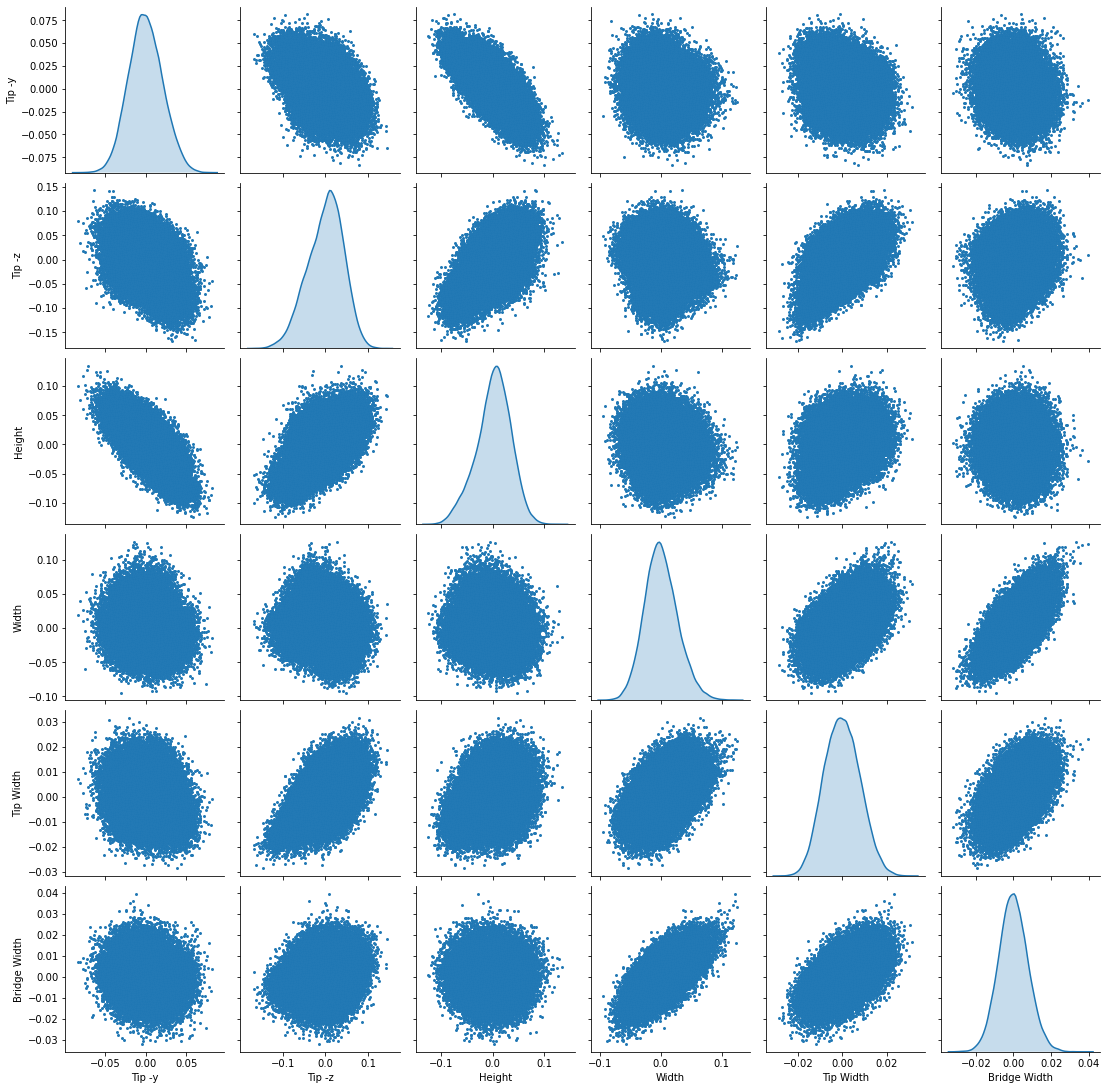

In [13]:
"""
Visualize the data
"""
import seaborn as sns
import pandas as pd

d = {
    'Tip -y': measurements_nose[:, 0],
    'Tip -z': measurements_nose[:, 1],
    'Height': measurements_nose[:, 2],
    'Width': measurements_nose[:, 3],
    'Tip Width': measurements_nose[:, 4],
    'Bridge Width': measurements_nose[:, 5]
}

df = pd.DataFrame(data=d)
print(df.head())

_ = sns.pairplot(df, 
                 plot_kws=dict(marker=".", linewidth=0.01), 
                 diag_kind="kde")



In [14]:
""" Save the data matrix """

#np.save('./cache/measurements/{}.npy'.format('S_nose'), measurements_nose)